In [1]:
import os
import cv2
import time
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import concurrent.futures
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [3]:
class LimitValidationAccuracy(Callback):
    def __init__(self, monitor='val_accuracy', threshold=0.95):
        super(LimitValidationAccuracy, self).__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get(self.monitor)
        if current_val_accuracy is not None and current_val_accuracy > self.threshold:
            print(f"\nValidation accuracy reached {current_val_accuracy:.4f} > {self.threshold:.4f}. Stopping training.")
            self.model.stop_training = True

In [4]:
CLASS_LIST = sorted(os.listdir('/kaggle/input/foodition-dataset/dataset/'))
print(CLASS_LIST)

['apple - edible', 'apple - inedible', 'banana - edible', 'banana - inedible', 'bread - edible', 'bread - inedible', 'chicken - edible', 'chicken - inedible', 'donut - edible', 'donut - inedible', 'edible', 'egg - edible', 'egg - inedible', 'mango - edible', 'mango - inedible', 'orange - edible', 'orange - inedible', 'pizza - edible', 'pizza - inedible', 'potato - edible', 'potato - inedible', 'rice - edible', 'rice - inedible', 'tomato - edible', 'tomato - inedible']


In [5]:
file_path = "/kaggle/input/foodition-dataset/dataset/{}"
data = {}

for f in CLASS_LIST:
    data[f] = []

for col in CLASS_LIST:
    os.chdir(file_path.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg') or i.endswith('.png') or i.endswith('.jpeg'):
            data[col].append(i)


In [6]:
data_count = {key: len(value) for key, value in data.items()}
total_data_count = sum(data_count.values())
print(data_count)


{'apple - edible': 505, 'apple - inedible': 538, 'banana - edible': 513, 'banana - inedible': 600, 'bread - edible': 742, 'bread - inedible': 482, 'chicken - edible': 531, 'chicken - inedible': 540, 'donut - edible': 708, 'donut - inedible': 526, 'edible': 540, 'egg - edible': 486, 'egg - inedible': 484, 'mango - edible': 542, 'mango - inedible': 544, 'orange - edible': 512, 'orange - inedible': 512, 'pizza - edible': 426, 'pizza - inedible': 560, 'potato - edible': 536, 'potato - inedible': 553, 'rice - edible': 593, 'rice - inedible': 558, 'tomato - edible': 592, 'tomato - inedible': 525}


In [7]:
sample_size = total_data_count
print(sample_size)
width = 160
height = 160

13648


In [13]:
for f in CLASS_LIST :
    print(f)

apple - edible
apple - inedible
banana - edible
banana - inedible
bread - edible
bread - inedible
chicken - edible
chicken - inedible
donut - edible
donut - inedible
edible
egg - edible
egg - inedible
mango - edible
mango - inedible
orange - edible
orange - inedible
pizza - edible
pizza - inedible
potato - edible
potato - inedible
rice - edible
rice - inedible
tomato - edible
tomato - inedible


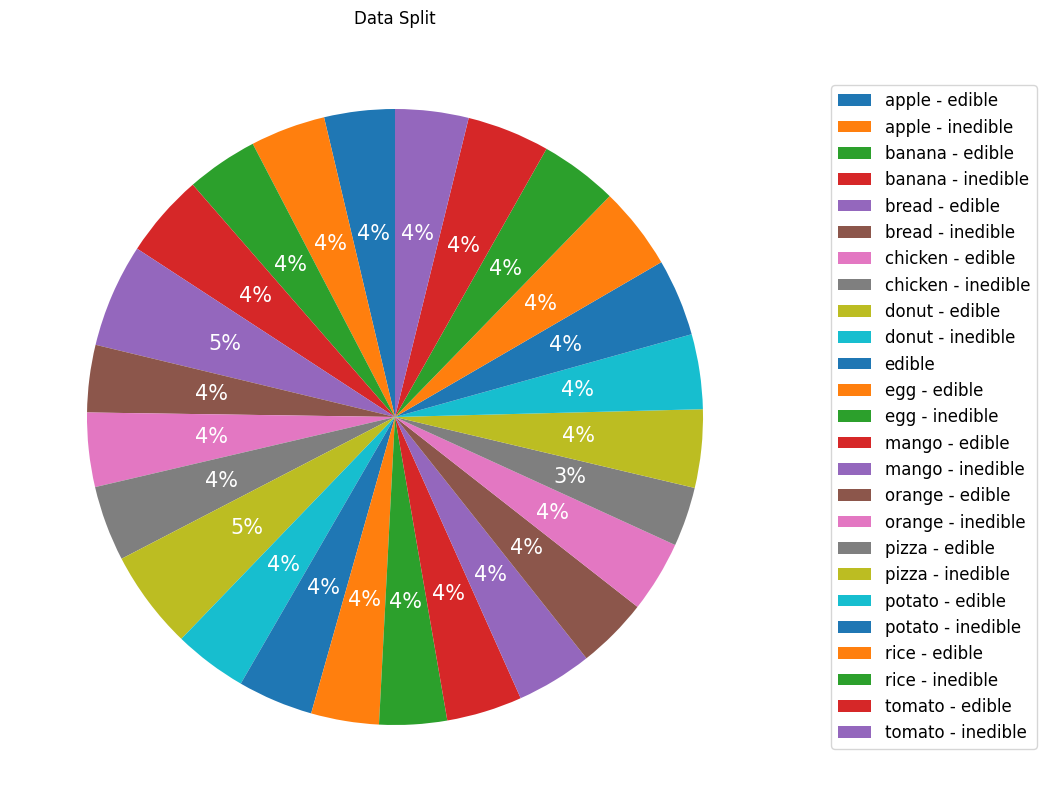

In [37]:
sizes = [len(data[f]) for f in CLASS_LIST]

plt.figure(figsize=(10, 10), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color': "w", "fontsize": 15}, startangle=90)
legend_labels = []
for cls in CLASS_LIST:
    legend_labels.extend([f"{cls}"])

plt.legend(legend_labels, loc="center", bbox_to_anchor=(1.2, 0.5), fontsize=12)
plt.title("Data Split")
plt.show()

In [44]:
datagen = image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.1)

train_generator = datagen.flow_from_directory(
        '/kaggle/input/foodition-dataset/dataset/',
        target_size=(160, 160),
        batch_size=16,
        shuffle=True,
        class_mode='categorical',
        subset= 'training')

validation_generator = datagen.flow_from_directory(
        '/kaggle/input/foodition-dataset/dataset/',
        target_size=(160, 160),
        batch_size=16,
        shuffle=False,
        class_mode='categorical',
        subset= 'validation')

Found 12292 images belonging to 25 classes.
Found 1356 images belonging to 25 classes.


In [ ]:
# start = time.time()
# image_data = []
# image_target = []

# for title in CLASS_LIST:
#     os.chdir(file_path.format(title))
#     counter = 0
#     for i in data[title]:
#         img = cv2.imread(i)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         image_data.append(cv2.resize(img,(width, height), interpolation=cv2.INTER_AREA))
#         image_target.append(title)
#         counter += 1
#         if counter == sample_size:
#             break

#     # Clear output less frequently and after processing a certain number of images
#     if counter % 100 == 0:
#         clear_output(wait=True)
#         print("Compiled Class",title)

# calculate_time = time.time() - start
# print("Calculate Time",round(calculate_time,5))

In [ ]:
# image_data = np.array(image_data)
# size = image_data.shape[0]
# image_data.shape

In [ ]:
# plt.figure(figsize=(15,15))
# for i in range(1,17):
#     fig = np.random.choice(np.arange(size))
#     plt.subplot(4,4,i)
#     plt.imshow(image_data[fig])
#     if 'edible' in image_target[fig]:
#         c='green'
#     else:
#         c='red'
#     plt.title(image_target[fig], color=c)
#     plt.xticks([]), plt.yticks([])
# plt.show()

In [ ]:
# labels = LabelEncoder()
# labels.fit(image_target)

In [ ]:
# X = image_data / 255.0
# y = labels.transform(image_target)
# train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [45]:
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(32, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(25, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    def lr_scheduler(epoch):
        return 0.001 * np.exp(-0.1 * epoch)
    
    limit_val_acc_callback = LimitValidationAccuracy(monitor='val_accuracy', threshold=0.94)
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=7,
                                                restore_best_weights=True)

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

    history = model.fit(train_generator, epochs=25, validation_data= validation_generator, callbacks=[lr_callback, limit_val_acc_callback, callback])

Epoch 1/25
769/769 [==============================] - 95s 112ms/step - loss: 1.9344 - accuracy: 0.3903 - val_loss: 0.8438 - val_accuracy: 0.7706 - lr: 0.0010
Epoch 2/25
769/769 [==============================] - 72s 93ms/step - loss: 1.1525 - accuracy: 0.6189 - val_loss: 0.6502 - val_accuracy: 0.7987 - lr: 9.0484e-04
Epoch 3/25
769/769 [==============================] - 72s 93ms/step - loss: 0.9364 - accuracy: 0.6764 - val_loss: 0.5798 - val_accuracy: 0.8068 - lr: 8.1873e-04
Epoch 4/25
769/769 [==============================] - 71s 93ms/step - loss: 0.8275 - accuracy: 0.7072 - val_loss: 0.5875 - val_accuracy: 0.8119 - lr: 7.4082e-04
Epoch 5/25
769/769 [==============================] - 72s 93ms/step - loss: 0.7507 - accuracy: 0.7345 - val_loss: 0.5634 - val_accuracy: 0.8282 - lr: 6.7032e-04
Epoch 6/25
769/769 [==============================] - 72s 94ms/step - loss: 0.6989 - accuracy: 0.7507 - val_loss: 0.5448 - val_accuracy: 0.8333 - lr: 6.0653e-04
Epoch 7/25
769/769 [=================

85/85 - 7s - loss: 0.6161 - accuracy: 0.8547 - 7s/epoch - 77ms/step


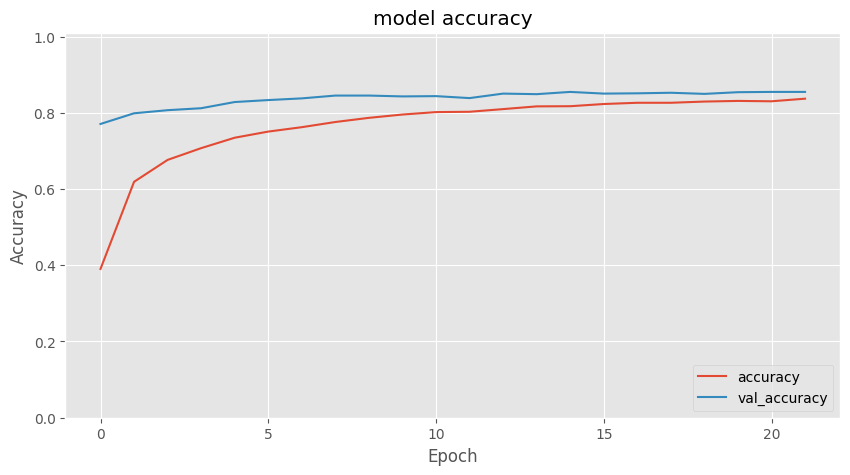

In [46]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(validation_generator, verbose=2)

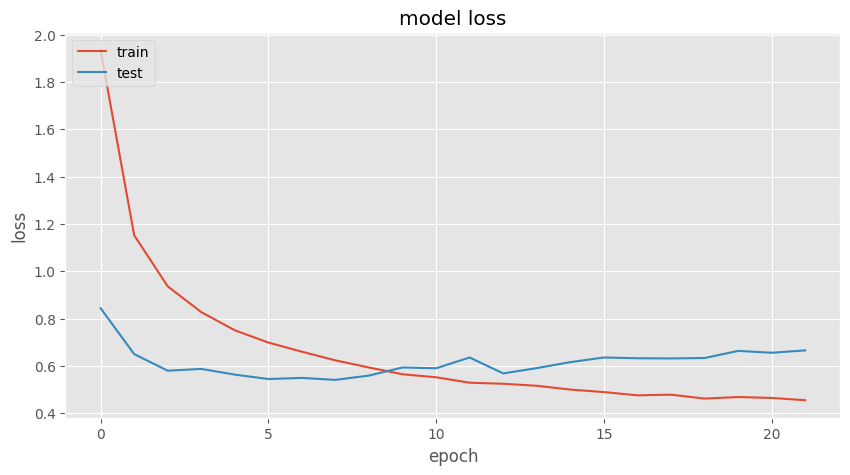

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 114ms/step


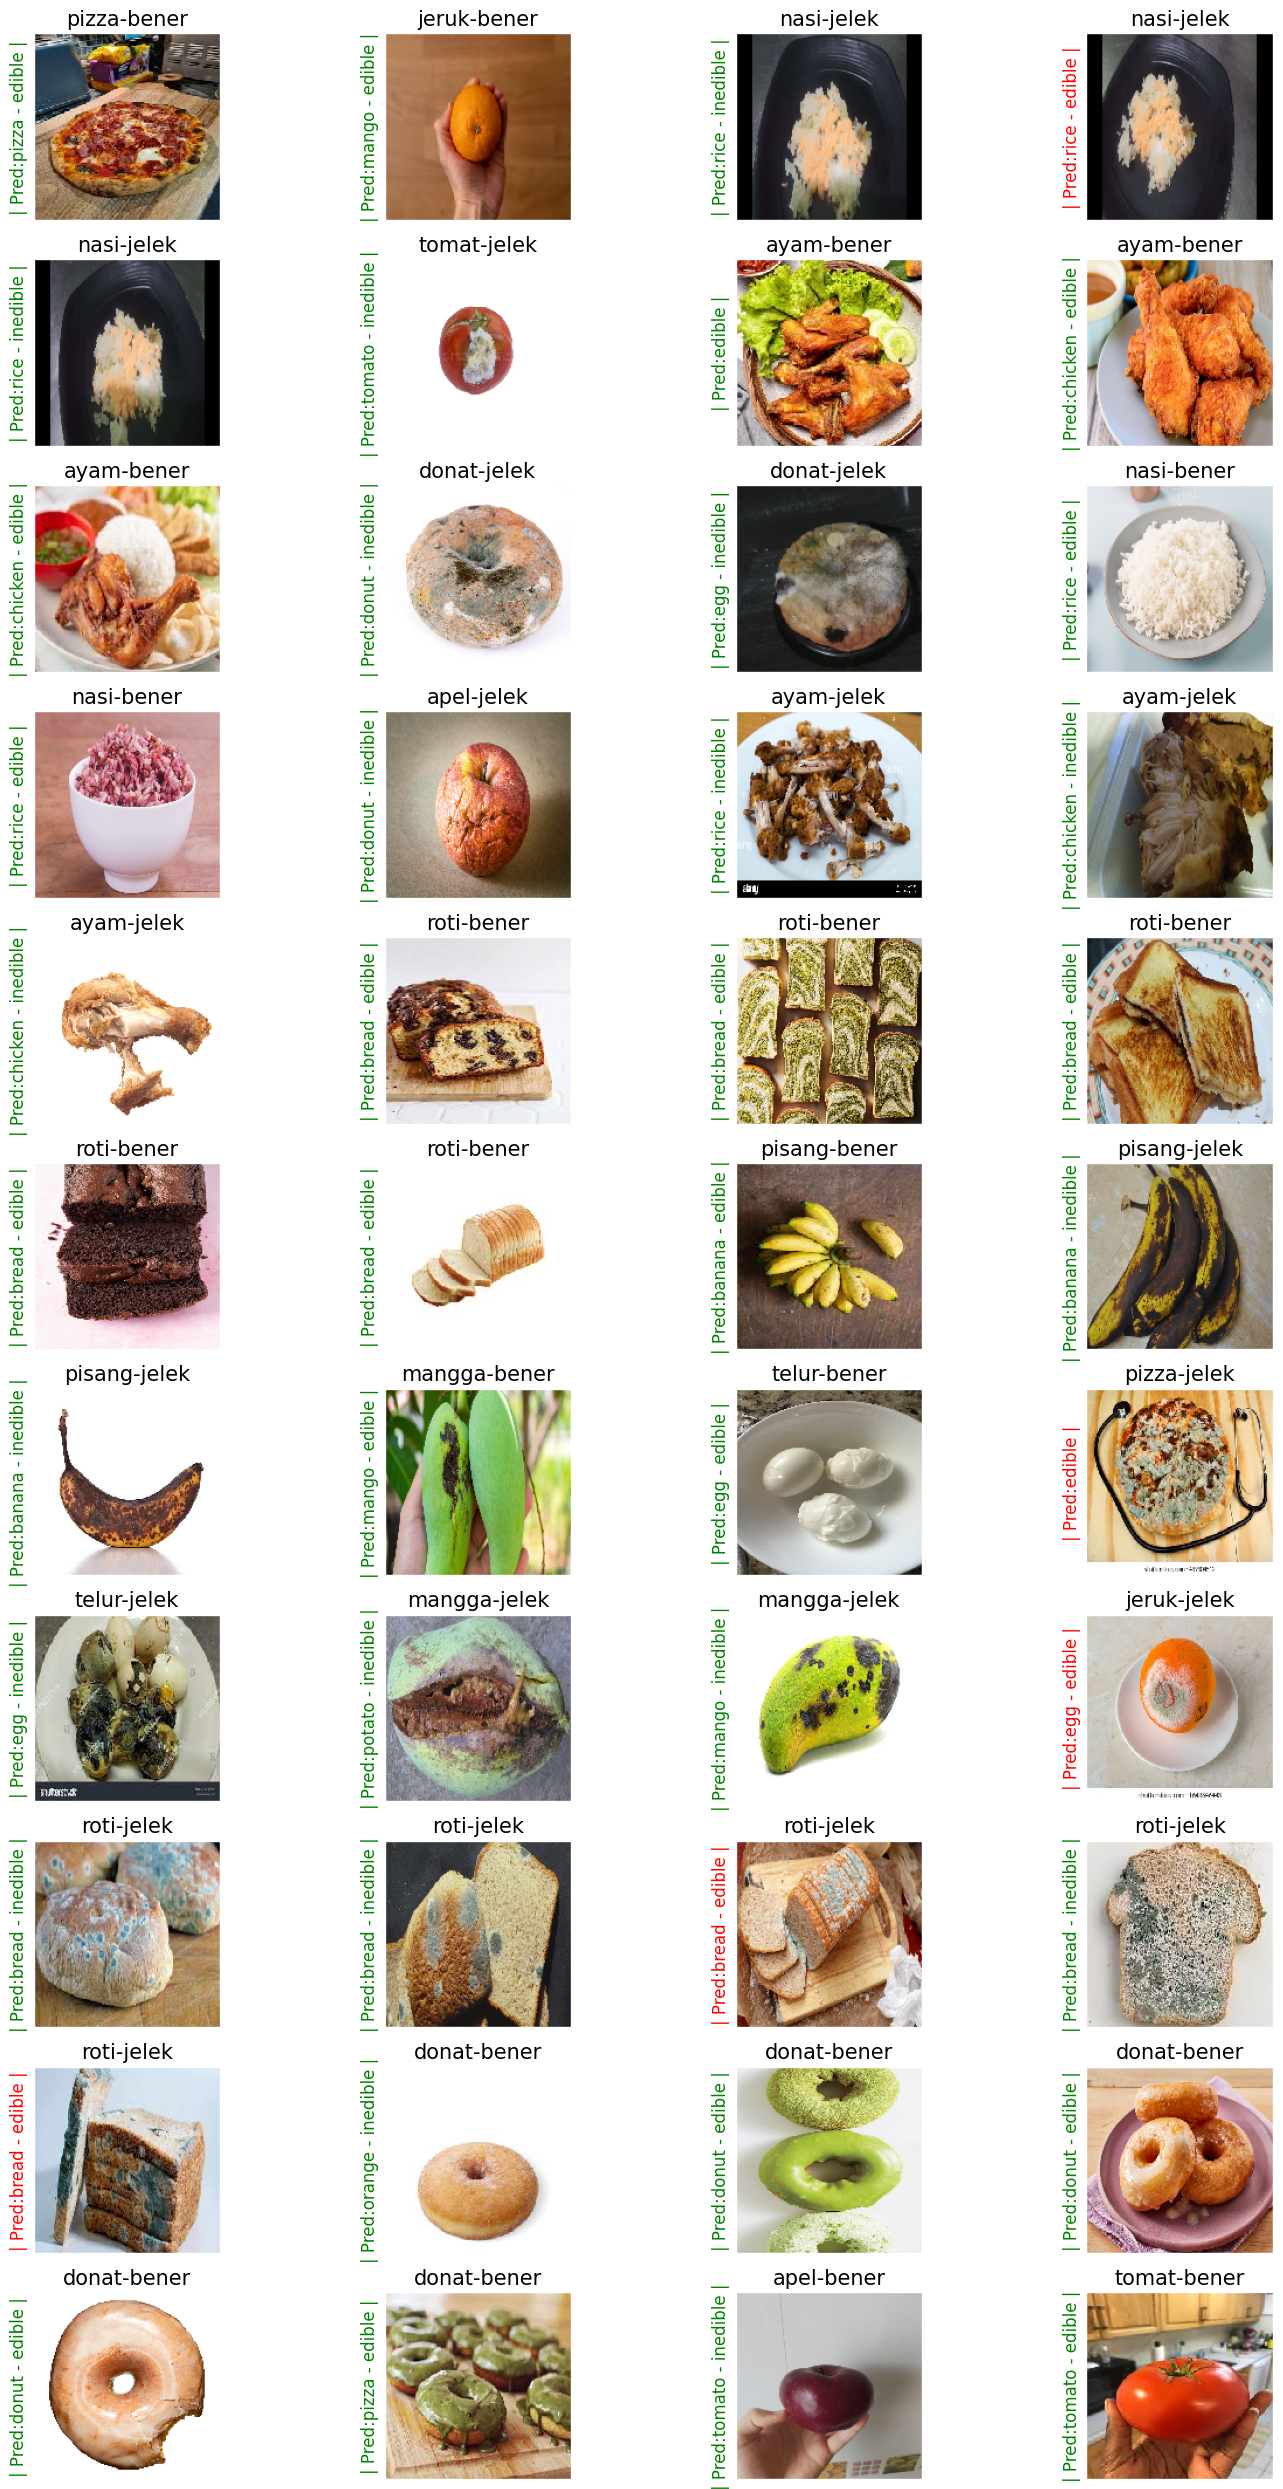

Incorrect Predictions:
Image: /kaggle/input/foodition-test/foodition-test/nasi-jelek/Screenshot_2024-01-09-21-19-04-055_com.miui.videoplayer.jpg
Actual Class: nasi-jelek
Predicted Class: rice - edible

Image: /kaggle/input/foodition-test/foodition-test/pizza-jelek/old-moldy-pizza-on-wooden-260nw-439304512.jpg
Actual Class: pizza-jelek
Predicted Class: edible

Image: /kaggle/input/foodition-test/foodition-test/jeruk-jelek/stale-orange-white-green-mold-260nw-1643846443.jpeg
Actual Class: jeruk-jelek
Predicted Class: egg - edible

Image: /kaggle/input/foodition-test/foodition-test/roti-jelek/well_moldy-tmagArticle.jpg
Actual Class: roti-jelek
Predicted Class: bread - edible

Image: /kaggle/input/foodition-test/foodition-test/roti-jelek/download (2).jpeg
Actual Class: roti-jelek
Predicted Class: bread - edible

Accuracy: 88.64%


In [48]:
file_path = "/kaggle/input/foodition-test/foodition-test/"
files = os.listdir(file_path)
data = {}

for col in files:
    os.chdir(os.path.join(file_path, col))
    data[col] = [i for i in os.listdir(os.getcwd()) if i.lower().endswith(('.jpg', '.jpeg', '.png'))]

correct_predictions = 0
total_predictions = 0
incorrect_predictions = []

# Set the number of rows and columns for subplots
num_rows = 11
num_cols = 4

# Set the size of the enlarged subplot
enlarged_subplot_size = (12, 12)

# Initialize subplot index
subplot_index = 1

# Create a new figure
plt.figure(figsize=(15, 25))

for col, images in data.items():
    for image_name in images:
        predict_path = os.path.join(file_path, col, image_name)

        img = image.load_img(predict_path, target_size=(160, 160))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0  # Normalization

        # Assuming `model` is already defined or deployed
        # Perform prediction
        classes = model.predict(x, batch_size=1)

        # Get predicted class before using it
        predicted_class = CLASS_LIST[np.argmax(classes[0])]

        # Create an enlarged subplot
        plt.subplot(num_rows, num_cols, subplot_index)
        plt.imshow(img)
        if ('-bener' in col and 'edible' not in predicted_class.lower()) or \
           ('-jelek' in col and 'inedible' not in predicted_class.lower()):
            c = 'red'
        else:
            c = 'green'
        plt.title(col, color='black', fontsize=15)
        plt.ylabel("| Pred:{} |".format(predicted_class), fontsize=12, color=c)
        plt.xticks([]), plt.yticks([])

        if ('-bener' in col and 'edible' not in predicted_class.lower()) or \
           ('-jelek' in col and 'inedible' not in predicted_class.lower()):
            incorrect_predictions.append({
                'image_path': predict_path,
                'actual_class': col,
                'predicted_class': predicted_class
            })
        else:
            correct_predictions += 1
        total_predictions += 1

        subplot_index += 1
        if subplot_index > num_rows * num_cols:
            subplot_index = 1

# Show any remaining figures
plt.tight_layout()
plt.show()

print("Incorrect Predictions:")
for prediction in incorrect_predictions:
    print(f"Image: {prediction['image_path']}")
    print(f"Actual Class: {prediction['actual_class']}")
    print(f"Predicted Class: {prediction['predicted_class']}")
    print()

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')

In [49]:
model.save('/kaggle/working/edible_food_classification_v11.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False, weights='imagenet')
    base_model.trainable = True
    
    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 120

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
    

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    def lr_scheduler(epoch):
        return 0.001 * np.exp(-0.1 * epoch)
    
    limit_val_acc_callback = LimitValidationAccuracy(monitor='val_accuracy', threshold=0.94)
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=17,
                                                restore_best_weights=True)

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

    history2 = model.fit(train_generator, epochs=35, validation_data= validation_generator, callbacks=[lr_callback, limit_val_acc_callback, callback])

Number of layers in the base model:  154
Epoch 1/35
769/769 [==============================] - 95s 114ms/step - loss: 0.5510 - accuracy: 0.8059 - val_loss: 0.6813 - val_accuracy: 0.8503 - lr: 0.0010
Epoch 2/35
769/769 [==============================] - 73s 95ms/step - loss: 0.5586 - accuracy: 0.7980 - val_loss: 0.7263 - val_accuracy: 0.8437 - lr: 9.0484e-04
Epoch 3/35
769/769 [==============================] - 73s 95ms/step - loss: 0.5196 - accuracy: 0.8087 - val_loss: 0.7908 - val_accuracy: 0.8326 - lr: 8.1873e-04
Epoch 4/35
769/769 [==============================] - 73s 95ms/step - loss: 0.4882 - accuracy: 0.8229 - val_loss: 0.6902 - val_accuracy: 0.8547 - lr: 7.4082e-04
Epoch 5/35
769/769 [==============================] - 74s 96ms/step - loss: 0.4613 - accuracy: 0.8305 - val_loss: 0.8116 - val_accuracy: 0.8473 - lr: 6.7032e-04
Epoch 6/35
769/769 [==============================] - 72s 94ms/step - loss: 0.4706 - accuracy: 0.8230 - val_loss: 0.7963 - val_accuracy: 0.8422 - lr: 6.0653e

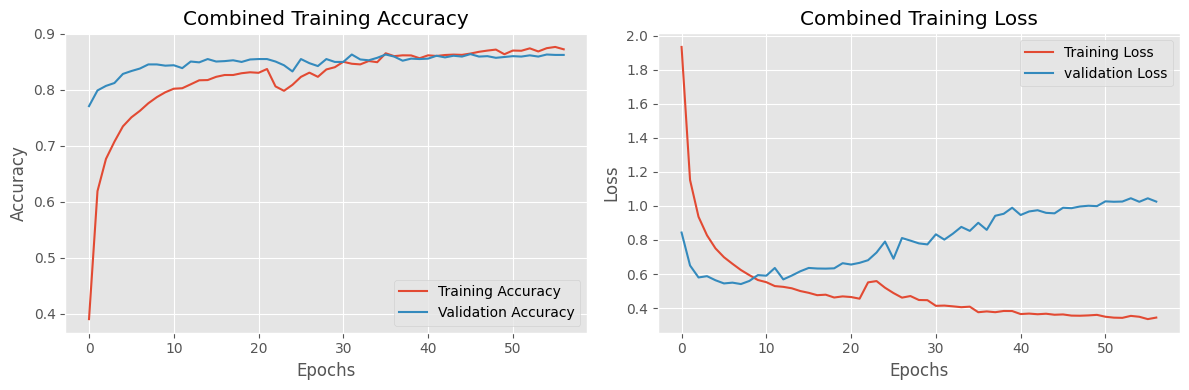

In [51]:
# Extract accuracy and loss from history1
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

# Extract accuracy and loss from history2
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

# Combine accuracy and loss from both histories
combined_acc = acc1 + acc2
combined_valacc = val_acc1 + val_acc2
combined_loss = loss1 + loss2
combined_valloss = val_loss1 + val_loss2

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(combined_acc, label='Training Accuracy')
plt.plot(combined_valacc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Combined Training Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(combined_loss, label='Training Loss')
plt.plot(combined_valloss, label='validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Combined Training Loss')
plt.legend()

plt.tight_layout()
plt.show()

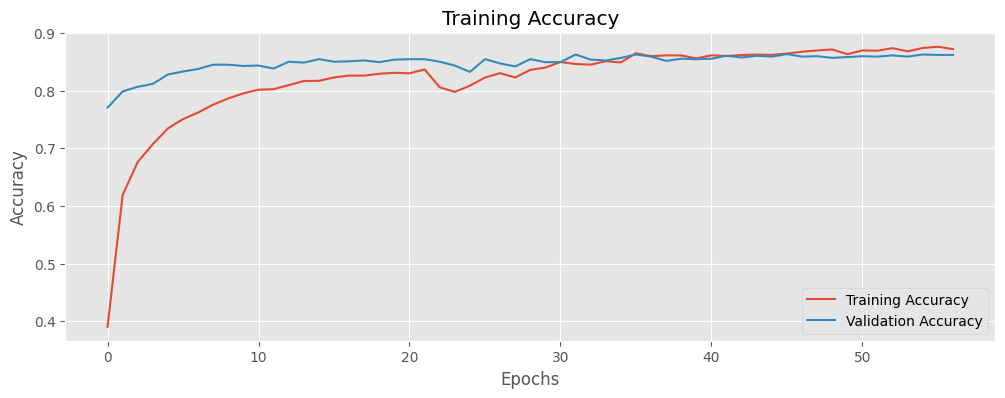

In [52]:
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.plot(combined_acc, label='Training Accuracy')
plt.plot(combined_valacc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

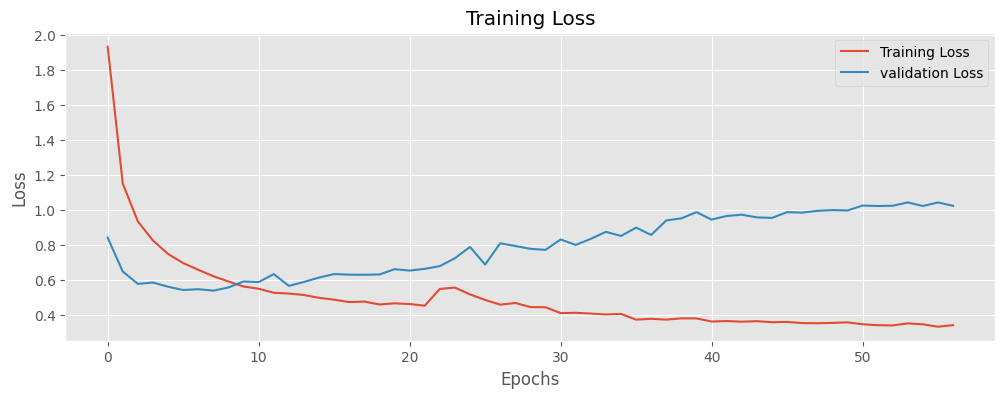

In [53]:
plt.figure(figsize=(12, 4))
plt.plot(combined_loss, label='Training Loss')
plt.plot(combined_valloss, label='validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

1/1 [==============================] - 0s 114ms/step


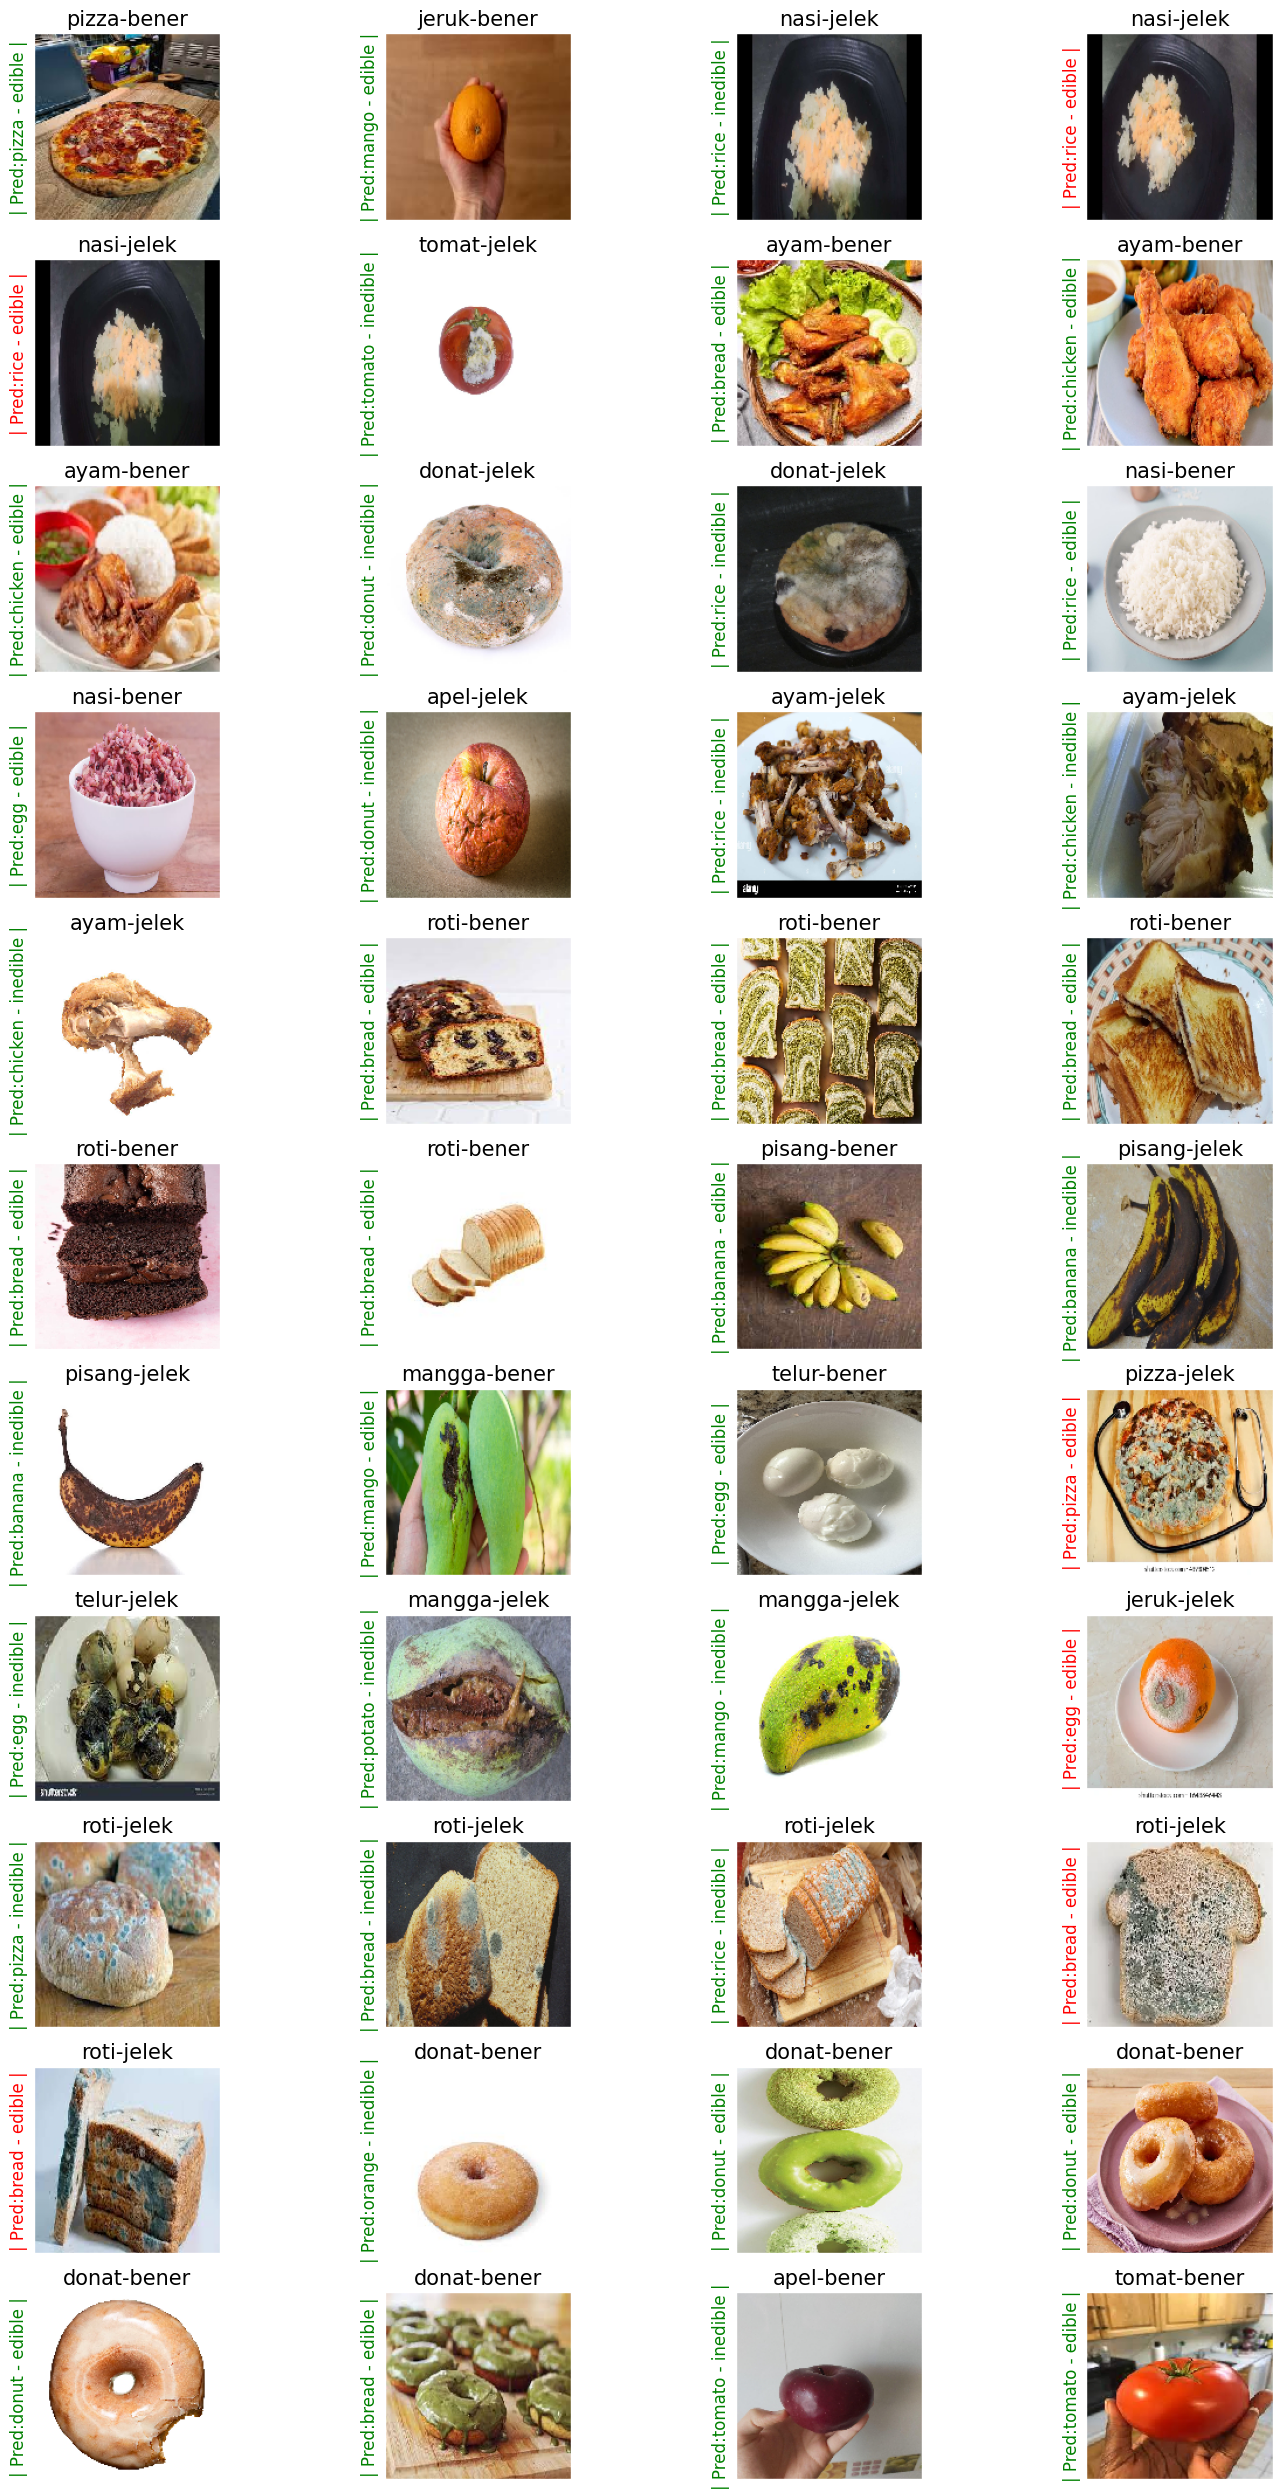

Incorrect Predictions:
Image: /kaggle/input/foodition-test/foodition-test/nasi-jelek/Screenshot_2024-01-09-21-19-04-055_com.miui.videoplayer.jpg
Actual Class: nasi-jelek
Predicted Class: rice - edible

Image: /kaggle/input/foodition-test/foodition-test/nasi-jelek/Screenshot_2024-01-09-21-19-07-249_com.miui.videoplayer.jpg
Actual Class: nasi-jelek
Predicted Class: rice - edible

Image: /kaggle/input/foodition-test/foodition-test/pizza-jelek/old-moldy-pizza-on-wooden-260nw-439304512.jpg
Actual Class: pizza-jelek
Predicted Class: pizza - edible

Image: /kaggle/input/foodition-test/foodition-test/jeruk-jelek/stale-orange-white-green-mold-260nw-1643846443.jpeg
Actual Class: jeruk-jelek
Predicted Class: egg - edible

Image: /kaggle/input/foodition-test/foodition-test/roti-jelek/content_bread_mould.jpg
Actual Class: roti-jelek
Predicted Class: bread - edible

Image: /kaggle/input/foodition-test/foodition-test/roti-jelek/download (2).jpeg
Actual Class: roti-jelek
Predicted Class: bread - edibl

In [54]:
file_path = "/kaggle/input/foodition-test/foodition-test/"
files = os.listdir(file_path)
data = {}

for col in files:
    os.chdir(os.path.join(file_path, col))
    data[col] = [i for i in os.listdir(os.getcwd()) if i.lower().endswith(('.jpg', '.jpeg', '.png'))]

correct_predictions = 0
total_predictions = 0
incorrect_predictions = []

# Set the number of rows and columns for subplots
num_rows = 11
num_cols = 4

# Set the size of the enlarged subplot
enlarged_subplot_size = (12, 12)

# Initialize subplot index
subplot_index = 1

# Create a new figure
plt.figure(figsize=(15, 25))

for col, images in data.items():
    for image_name in images:
        predict_path = os.path.join(file_path, col, image_name)

        img = image.load_img(predict_path, target_size=(160, 160))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0  # Normalization

        # Assuming `model` is already defined or deployed
        # Perform prediction
        classes = model.predict(x, batch_size=1)

        # Get predicted class before using it
        predicted_class = CLASS_LIST[np.argmax(classes[0])]

        # Create an enlarged subplot
        plt.subplot(num_rows, num_cols, subplot_index)
        plt.imshow(img)
        if ('-bener' in col and 'edible' not in predicted_class.lower()) or \
           ('-jelek' in col and 'inedible' not in predicted_class.lower()):
            c = 'red'
        else:
            c = 'green'
        plt.title(col, color='black', fontsize=15)
        plt.ylabel("| Pred:{} |".format(predicted_class), fontsize=12, color=c)
        plt.xticks([]), plt.yticks([])

        if ('-bener' in col and 'edible' not in predicted_class.lower()) or \
           ('-jelek' in col and 'inedible' not in predicted_class.lower()):
            incorrect_predictions.append({
                'image_path': predict_path,
                'actual_class': col,
                'predicted_class': predicted_class
            })
        else:
            correct_predictions += 1
        total_predictions += 1

        subplot_index += 1
        if subplot_index > num_rows * num_cols:
            subplot_index = 1

# Show any remaining figures
plt.tight_layout()
plt.show()

print("Incorrect Predictions:")
for prediction in incorrect_predictions:
    print(f"Image: {prediction['image_path']}")
    print(f"Actual Class: {prediction['actual_class']}")
    print(f"Predicted Class: {prediction['predicted_class']}")
    print()

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
# model.save('/kaggle/working/edible_food_classification_v12.h5')